In [176]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [177]:
# Regression dataset from sklearn diabetes dataset

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

X, y = load_diabetes(return_X_y=True)

# Train, validation, test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert to torch tensors
X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()

y_train = torch.from_numpy(y_train).float().view(-1, 1)
y_val = torch.from_numpy(y_val).float().view(-1, 1)
y_test = torch.from_numpy(y_test).float().view(-1, 1)

# Create dataloaders
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=32, shuffle=True)
val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=32, shuffle=False)
test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=32, shuffle=False)

In [178]:
# Model 1: Linear regression

class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return self.linear(x)


In [207]:
def train(model, optimizer, criterion = nn.MSELoss(), train_loader=None, val_loader=None, epochs=1000):
    train_losses = []
    val_losses = []
    for e in range(epochs):
        train_loss = 0
        val_loss = 0
        model.train()
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch_x.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                output = model(batch_x)
                loss = criterion(output, batch_y)
                val_loss += loss.item() * batch_x.size(0)
            val_loss /= len(val_loader.dataset)
            val_losses.append(val_loss)

        if (e+1) % 100 == 0:
            print(f'Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
    
    return train_losses, val_losses


Epoch 100/1000, Train Loss: 10315.2895, Validation Loss: 12724.1896
Epoch 200/1000, Train Loss: 4804.3067, Validation Loss: 5319.9323
Epoch 300/1000, Train Loss: 3715.5066, Validation Loss: 3480.5550
Epoch 400/1000, Train Loss: 3388.3811, Validation Loss: 3083.5462
Epoch 500/1000, Train Loss: 3194.2672, Validation Loss: 2970.7406
Epoch 600/1000, Train Loss: 3075.9221, Validation Loss: 2929.4660
Epoch 700/1000, Train Loss: 3007.6152, Validation Loss: 2911.9031
Epoch 800/1000, Train Loss: 2970.0181, Validation Loss: 2906.4726
Epoch 900/1000, Train Loss: 2948.9850, Validation Loss: 2904.5393
Epoch 1000/1000, Train Loss: 2937.7591, Validation Loss: 2901.6748


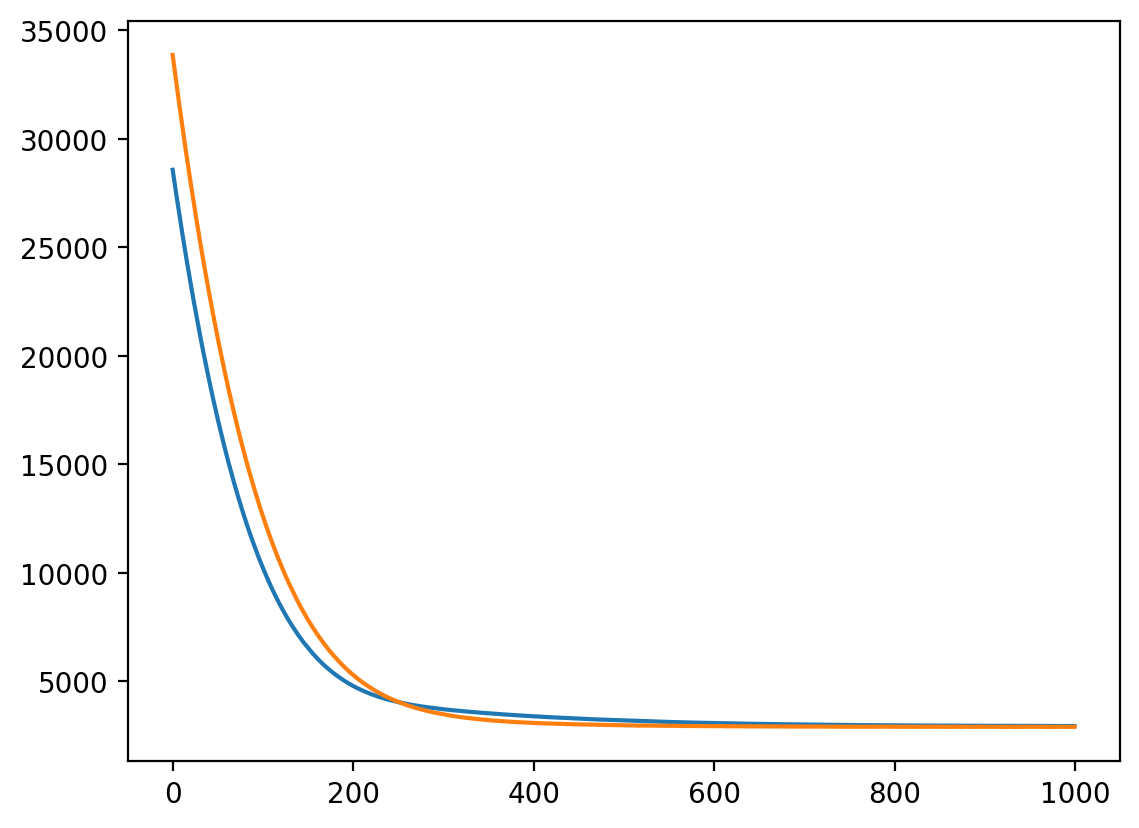

In [209]:
criterion = nn.MSELoss()

model = LinearRegression(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.1)

train_losses, val_losses = train(model, optimizer, criterion, train_loader, val_loader, epochs=1000)

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')


In [210]:
# RMSE on test set

def rmse(model, test_loader):
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch_x, batch_y in test_loader:
            output = model(batch_x)
            loss = criterion(output, batch_y)
            test_loss += loss.item() * batch_x.size(0)
        test_loss /= len(test_loader.dataset)
    return np.sqrt(test_loss)


In [212]:
errors = {}

errors["linreg"] = rmse(model, test_loader)

In [213]:
# Model 2: MLP

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


In [222]:
mlp = MLP(X_train.shape[1])
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

train_losses, val_losses = train(mlp, optimizer, criterion, train_loader, val_loader, epochs=1500)

Epoch 100/1500, Train Loss: 3663.8245, Validation Loss: 3086.0981
Epoch 200/1500, Train Loss: 3077.9123, Validation Loss: 2912.6680
Epoch 300/1500, Train Loss: 2952.4684, Validation Loss: 2906.0980
Epoch 400/1500, Train Loss: 2920.8557, Validation Loss: 2916.5231
Epoch 500/1500, Train Loss: 2908.5543, Validation Loss: 2903.3417
Epoch 600/1500, Train Loss: 2898.7857, Validation Loss: 2920.6625
Epoch 700/1500, Train Loss: 2888.3550, Validation Loss: 2886.4415
Epoch 800/1500, Train Loss: 2874.1253, Validation Loss: 2905.2355
Epoch 900/1500, Train Loss: 2866.0193, Validation Loss: 2915.6193
Epoch 1000/1500, Train Loss: 2858.1495, Validation Loss: 2914.3357
Epoch 1100/1500, Train Loss: 2849.0639, Validation Loss: 2919.2359
Epoch 1200/1500, Train Loss: 2835.6841, Validation Loss: 2927.5912
Epoch 1300/1500, Train Loss: 2814.3485, Validation Loss: 2942.1452
Epoch 1400/1500, Train Loss: 2802.6443, Validation Loss: 2928.9871
Epoch 1500/1500, Train Loss: 2789.4206, Validation Loss: 2943.3993


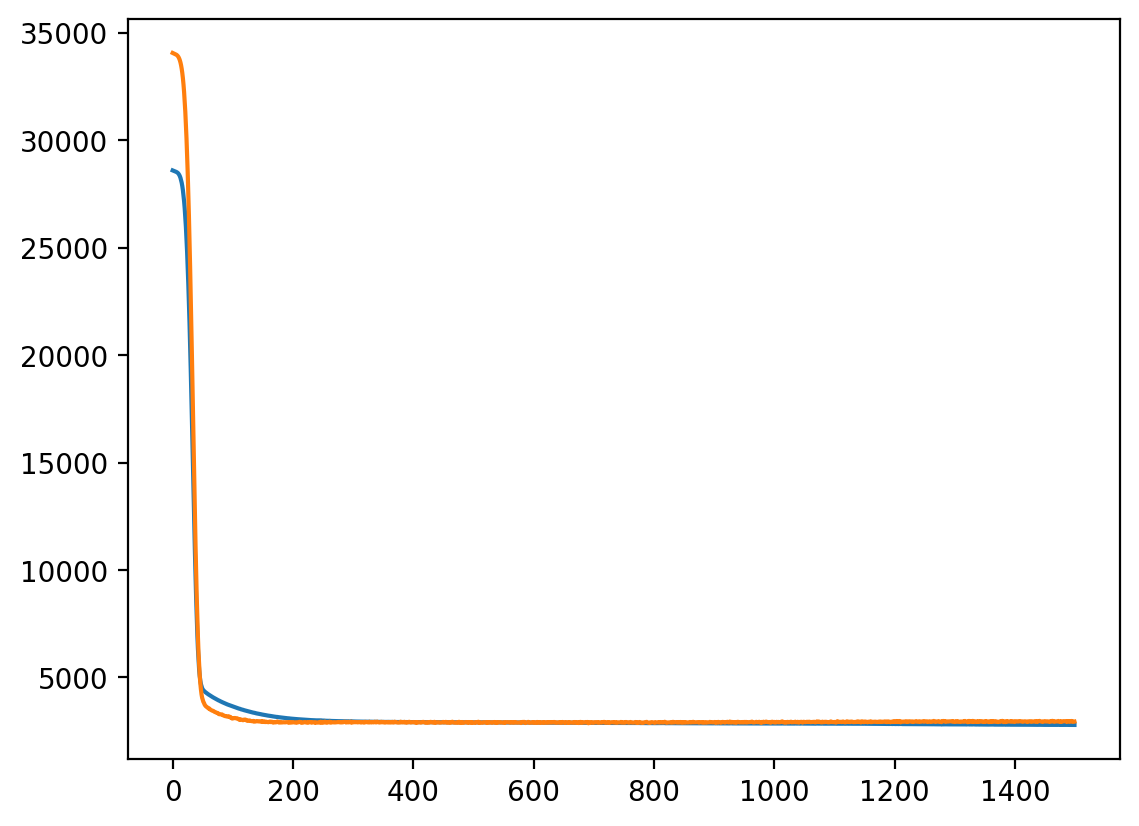

In [223]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')

In [224]:
errors["MLP"]= rmse(mlp, test_loader)
errors

{'linreg': 53.8179193310273, 'MLP': 51.32108141562702}

In [225]:
# Model 3: Residual MLP

# Adding a skip connection from input to output

class ResMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32 + input_dim, 16)
        self.fc3 = nn.Linear(16 + input_dim, 10)
        self.fc4 = nn.Linear(10, 1)
        
    def forward(self, x):
        x_inp = x
        x = F.relu(self.fc1(x)) 
        # Concatenate input to output of first layer
        x = torch.cat((x, x_inp), dim=1)
        x = F.relu(self.fc2(x))

        # Concatenate input to output of second layer
        x = torch.cat((x, x_inp), dim=1)
        x = F.relu(self.fc3(x))

        return self.fc4(x)


In [226]:
res_mlp = ResMLP(X_train.shape[1])
res_mlp(X_train).shape

torch.Size([282, 1])

In [227]:
res_mlp = ResMLP(X_train.shape[1])
optimizer = optim.Adam(res_mlp.parameters(), lr=0.001)

train_losses, val_losses = train(res_mlp, optimizer, criterion, train_loader, val_loader, epochs=1500)

Epoch 100/1500, Train Loss: 3298.6719, Validation Loss: 2937.0046
Epoch 200/1500, Train Loss: 2958.9598, Validation Loss: 2908.0027
Epoch 300/1500, Train Loss: 2933.4946, Validation Loss: 2915.9148
Epoch 400/1500, Train Loss: 2924.1275, Validation Loss: 2885.2503
Epoch 500/1500, Train Loss: 2918.3424, Validation Loss: 2883.3218
Epoch 600/1500, Train Loss: 2913.7633, Validation Loss: 2891.1281
Epoch 700/1500, Train Loss: 2909.4774, Validation Loss: 2875.5787
Epoch 800/1500, Train Loss: 2906.8811, Validation Loss: 2885.1002
Epoch 900/1500, Train Loss: 2896.1299, Validation Loss: 2894.3401
Epoch 1000/1500, Train Loss: 2881.0517, Validation Loss: 2883.1614
Epoch 1100/1500, Train Loss: 2859.3730, Validation Loss: 2900.0346
Epoch 1200/1500, Train Loss: 2843.1591, Validation Loss: 2892.0867
Epoch 1300/1500, Train Loss: 2825.5589, Validation Loss: 2935.1988
Epoch 1400/1500, Train Loss: 2807.9256, Validation Loss: 2898.6540
Epoch 1500/1500, Train Loss: 2798.3861, Validation Loss: 2901.6544


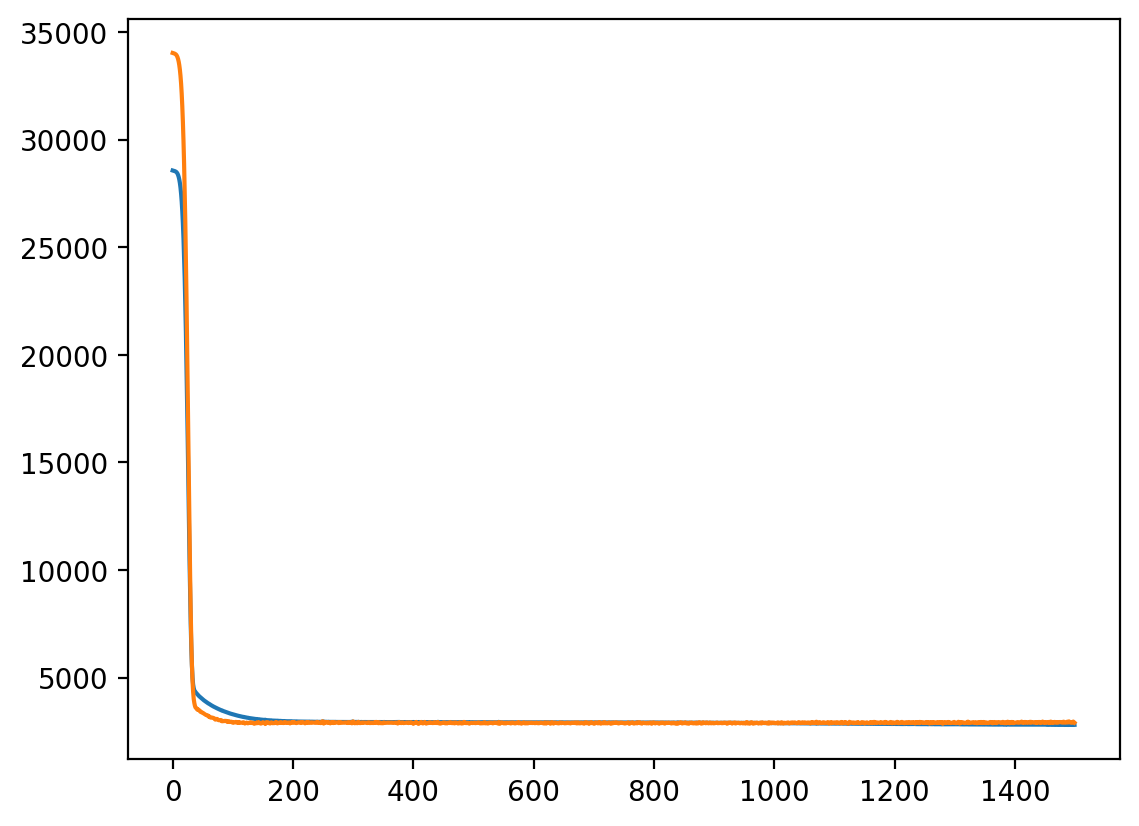

In [228]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')

In [231]:
errors["resnet"] = rmse(res_mlp, test_loader)
errors

{'linreg': 53.8179193310273,
 'MLP': 51.32108141562702,
 'resnet': 51.87944353261233}

In [232]:
# Adding LR scheduler
def train(model, optimizer, criterion=nn.MSELoss(), epochs=1000, lr_scheduler=None):
    train_losses = []
    val_losses = []

    for e in range(epochs):
        # Training loop
        train_loss = 0
        model.train()  # set the model to training mode
        for X_train_batch, y_train_batch in train_loader:
            optimizer.zero_grad()
            y_train_pred = model(X_train_batch)
            loss = criterion(y_train_pred, y_train_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        # Validation loop
        val_loss = 0
        model.eval()  # set the model to evaluation mode
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                y_val_pred = model(X_val_batch)
                loss = criterion(y_val_pred, y_val_batch)
                val_loss += loss.item()
            val_losses.append(val_loss / len(val_loader))

        # Update learning rate
        if lr_scheduler is not None:
            lr_scheduler.step(val_losses[-1])

        # Print progress
        if e % 100 == 0:
            print(f"Epoch {e}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses


In [236]:
# Use a LRPlateau scheduler to reduce the learning rate when the validation loss stops improving

from torch.optim.lr_scheduler import ReduceLROnPlateau

res_mlp = ResMLP(X_train.shape[1])

optimizer = optim.Adam(res_mlp.parameters(), lr=0.01)

lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)

train_losses, val_losses = train(res_mlp, optimizer, criterion, epochs=1500, lr_scheduler=lr_scheduler)

Epoch 0, Train Loss: 28639.6855, Val Loss: 33158.0742
Epoch 100, Train Loss: 2911.0527, Val Loss: 2420.7449
Epoch 00141: reducing learning rate of group 0 to 5.0000e-03.
Epoch 00192: reducing learning rate of group 0 to 2.5000e-03.
Epoch 200, Train Loss: 2815.0154, Val Loss: 2422.1171
Epoch 00243: reducing learning rate of group 0 to 1.2500e-03.
Epoch 00294: reducing learning rate of group 0 to 6.2500e-04.
Epoch 300, Train Loss: 2783.4652, Val Loss: 2429.3894
Epoch 00345: reducing learning rate of group 0 to 3.1250e-04.
Epoch 00396: reducing learning rate of group 0 to 1.5625e-04.
Epoch 400, Train Loss: 2794.7555, Val Loss: 2432.0923
Epoch 00447: reducing learning rate of group 0 to 7.8125e-05.
Epoch 00498: reducing learning rate of group 0 to 3.9063e-05.
Epoch 500, Train Loss: 2799.6670, Val Loss: 2432.4159
Epoch 00549: reducing learning rate of group 0 to 1.9531e-05.
Epoch 00600: reducing learning rate of group 0 to 9.7656e-06.
Epoch 600, Train Loss: 2773.7532, Val Loss: 2431.9507
Ep

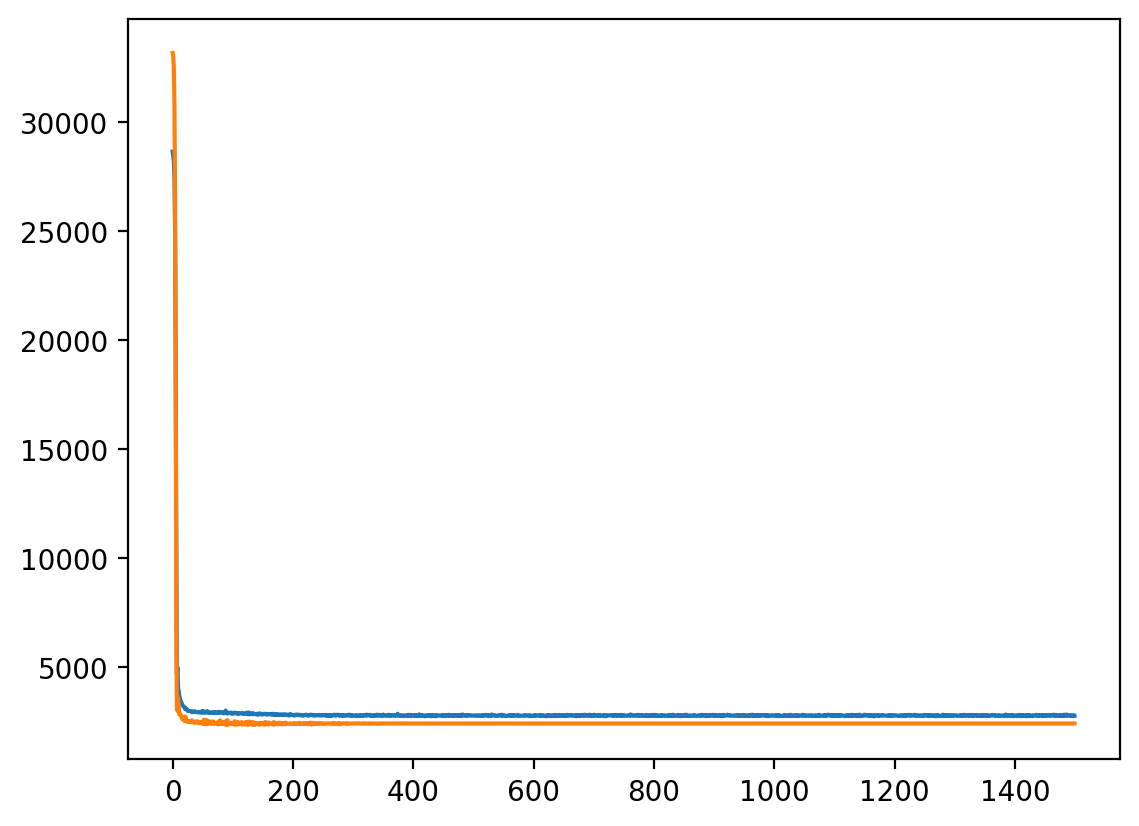

In [237]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')

In [241]:
errors["resnet-lr"] = rmse(res_mlp, test_loader)

<AxesSubplot: >

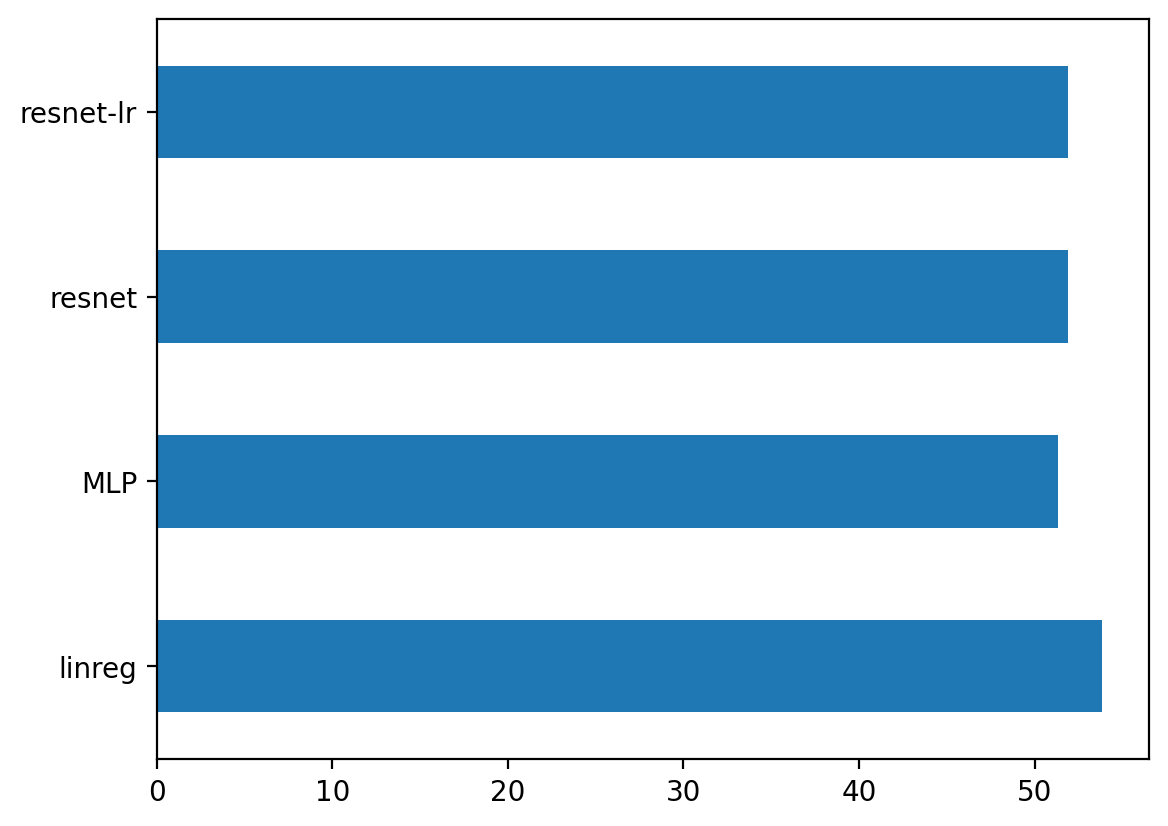

In [242]:
import pandas as pd
pd.Series(errors).plot.barh()